# Recommendation Engine for Movie Reviews
Factorization Machine (FM) is one of the newest algorithms in the Machine Learning space, and has been developed in SAS. FM is a general prediction algorithm, similar to Support Vector Machines, that can deal with very sparce data, an area where traditional Machine Learning techniques fail.
<br>

Recommendation Engines are notoriously difficult due to their sparcity. We have many users and many rated items, but most users have rated very few of the items. Therefore, we will try to use a Factorization Machine to implement new movie recommendations for users
<br>

This notebook has **Five** parts:
1. Notebook Setup & Server Connection 
2. Data Exploration
2. Recommendation Engine Considerations
3. Train Recommendation Engine
4. Make Recommendations

# Part I: Notebook Setup & Server Conneciton
In this section, we will load the necessary Python Packages, as well as set up a connection to our CAS Server
<br>

Our API is contained in our swat package, which will convert Python syntax below into language the CAS server can understand and execute. Results are then brought back to the Python Client

In [29]:
#Load Packages
import swat
from swat import *
from swat.render import render_html
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline
from IPython.display import HTML
swat.options.cas.print_messages = True

In [30]:
# Connect to the session
s = CAS(cashost, casport)

# Define directory and data file name
indata_dir="/viyafiles/ankram/Data"
indata='movie_reviews'
movie_info= 'Movies_10k_desc_final'

# Create a CAS library called DMLib pointing to the defined directory
## Note, need to specify the srctype is path, otherwise it defaults to HDFS
s.table.addCaslib(datasource={'srctype':'path'}, name='DMlib', path=indata_dir);

# Push the relevant table In-Memory if it does not already exist
## Note, this is a server side data load, not being loaded from the client
a = s.loadTable(caslib='DMlib', path=indata+'.sas7bdat', casout={'name':indata});
b = s.loadTable(caslib='DMlib', path=movie_info+'.sas7bdat', casout={'name':movie_info});

# Load necessary actionsets
actions = ['fedSQL', 'transpose','sampling','factmac','astore', 'recommend']
[s.loadactionset(i) for i in actions]

# Set variables for later use by models
target          = 'rating'
class_inputs    = ['usr_id', 'movie']
all_inputs      = [target] + class_inputs

#Pointer Shortcut
indata_p = a.casTable
movie_info_p = b.casTable

NOTE: 'DMlib' is now the active caslib.
NOTE: Cloud Analytic Services added the caslib 'DMlib'.
NOTE: Cloud Analytic Services made the file movie_reviews.sas7bdat available as table MOVIE_REVIEWS in caslib DMlib.
NOTE: Cloud Analytic Services made the file Movies_10k_desc_final.sas7bdat available as table MOVIES_10K_DESC_FINAL in caslib DMlib.
NOTE: Added action set 'fedSQL'.
NOTE: Added action set 'transpose'.
NOTE: Added action set 'sampling'.
NOTE: Added action set 'factmac'.
NOTE: Added action set 'astore'.
NOTE: Added action set 'recommend'.


# Part 2: Data Exploration
### We have the following input datasets/explorations available:
* Movie Dataset: Additional metadata, such as year, genre, and parental rating for movies
* User Ratings: Movie Ratings available for each user
* Overall Average: Average Rating across all users and movie
<br>

Our goal is to recommend two new movies for each user

## Movie Dataset

In [31]:
#See Overview Data
print(len(indata_p), "Movies")
movie_info_p[movie_info_p.columns[0:7]].head()

10000 Movies


,movieId,title,year,genres,parental_rating,Action,Adventure
0,1.0,Toy Story,1995.0,Adventure|Animation|Children|Comedy|Fantasy,G,0.0,1.0
1,2.0,Jumanji,1995.0,Adventure|Children|Fantasy,PG,0.0,1.0
2,3.0,Grumpier Old Men,1995.0,Comedy|Romance,PG-13,0.0,0.0
3,4.0,Waiting to Exhale,1995.0,Comedy|Drama|Romance,R,0.0,0.0
4,5.0,Father of the Bride Part II,1995.0,Comedy,PG,0.0,0.0


In [32]:
#Distribution of Parental Ratings
movie_info_p['parental_rating'].value_counts()

R            490
PG-13        179
PG           168
APPROVED      62
G             44
NOT RATED     35
UNRATED       28
PASSED         8
NC-17          3
GP             2
TV-14          2
X              2
TV-PG          1
dtype: int64

## User Ratings

In [33]:
print(len(indata_p), "Ratings")
print(len(indata_p[class_inputs[0]].value_counts()), "Users")
indata_p.head()

10000 Ratings
385 Users


,usr_id,movie,rating
0,196.0,242.0,3.0
1,186.0,302.0,3.0
2,22.0,377.0,1.0
3,244.0,51.0,2.0
4,166.0,346.0,1.0


## Distribution of Overall Reviews

3.5588 Average Review


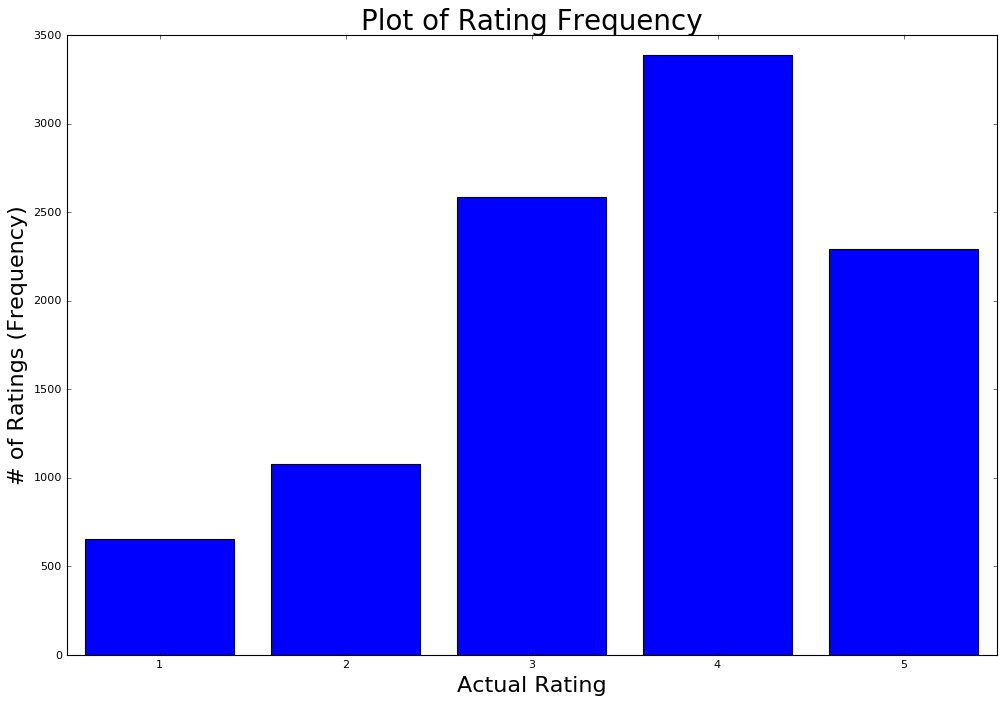

In [34]:
freq_table = (s.fedSQL.execDirect('''
    SELECT ''' + target + ''', count(*) as Frequency
    FROM '''+ indata +'''
    GROUP BY ''' + target + ''';
''')['Result Set'].sort_values(target)).set_index(np.arange(1,6))

plt.figure(figsize = (15, 10))
plt.bar(np.arange(1,6),freq_table['FREQUENCY'], align='center')
plt.xlabel('Actual Rating', size=20)
plt.ylabel('# of Ratings (Frequency)', size=20)
plt.title('Plot of Rating Frequency', size=25)
plt.xlim([.5,5.5]);
print(indata_p[target].mean(), "Average Review")

# Part III: Recommendation Engine Considerations
## Two Items to Consider:
* Holdout Sample: For Validation of Model
* Model Bias:
    * Global Bias: Average rating for all users and movies
    * User Bias: Average rating per user
    * Movie Bias: Average rating per movie
<br>




## Holdout Sample
Factorization machines need to be validated on users and movies that have been included in the training
<br>
To accomplish this, we will stratify on both user and movie
<br>
We will use a large training sample of ~90% of the data

In [35]:
# Create a 70/30 stratified Split on Users
s.sampling.stratified(
    table   = dict(name = indata, groupby = class_inputs[0]),
    output  = dict(casOut = dict(name = indata + '_prt_' + class_inputs[0], replace = True), copyVars = 'ALL'),
    samppct = 70,
    partind = True,
    seed    = 123
)

# Create a 70/30 split for the movies
s.sampling.stratified(
    table   = dict(name = indata, groupby = class_inputs[1]),
    output  = dict(casOut = dict(name = indata + '_prt_' + class_inputs[1], replace = True), copyVars = 'ALL'),
    samppct = 70,
    partind = True,
    seed    = 123
)

# Combine the samples together into one dataset so that it's stratified by user and movie
# Make the data 'blind' if it is part of the validation set so that it can be assessed
s.fedSQL.execDirect('''
    CREATE TABLE ''' + indata +'''_prt {options replace=true} AS
    SELECT
        a.''' + class_inputs[0] + ''',
        a.''' + class_inputs[1] + ''',
        a.''' + target + ''',
        CASE WHEN a._PartInd_ + b._PartInd_ > 0 THEN 1 ELSE 0 END AS _PartInd_
    FROM 
        ''' + indata + '_prt_' + class_inputs[0] + ''' a
        INNER JOIN ''' + indata + '_prt_' + class_inputs[1] + ''' b 
            ON  a.''' + class_inputs[0] + ' = b.' + class_inputs[0] + '''
            AND a.''' + class_inputs[1] + ' = b.' + class_inputs[1] + ''';
''')

s.CASTable(indata + '_prt')[all_inputs].query('_PartInd_=0').head()

NOTE: Using SEED=123 for sampling.
NOTE: Using SEED=123 for sampling.
NOTE: Table MOVIE_REVIEWS_PRT was created in caslib DMlib with 10000 rows returned.


,rating,usr_id,movie
0,2.0,244.0,51.0
1,4.0,63.0,277.0
2,3.0,50.0,246.0
3,4.0,7.0,32.0
4,4.0,251.0,100.0


## Bias Tables

Bias occurs because users unknowingly rate on different scales. Thus, a four star rating does not mean the same thing for two different users
<br>

The Factorization Machine accounts for this bias by assuming a predicted rating is the sum of:
1. A global bias (the average rating over all users and movies)
2. A per-user bias (the average of the ratings given by the user)
3. A per-item bias (the average of the ratings given to that movie)
4. And a pairwise interaction term between the user and that particular item

<br>
Factorization Machines account for these innate biases when making predictions, and are able to estimate the pairwise interactions between specific users and movies in sparse data.

### Overall Bias

In [36]:
indata_p[target].mean()

3.5588000000000002

### User Bias Table

In [37]:
# We can use SQL to find this, and further format using Python - sort_values() and head()
render_html(
s.fedSQL.execDirect('''
    SELECT 
        ''' + class_inputs[0] + ''', 
        COUNT(''' + target + ''') AS num_ratings, 
        AVG(''' + target + ''') AS avg_rating,
        AVG(''' + target + ''')-3.55 AS user_bias
    FROM ''' + indata + '''
    GROUP BY usr_id
''')['Result Set'].sort_values(class_inputs[0]).head()
)

1,85,3.6235294118,0.0735294118
2,12,3.5,-0.05
3,15,2.4,-1.15
4,6,4,0.45
5,48,2.9166666667,-0.633333333


### Movie Bias Table

In [38]:
# I could use SQL to find this as well, but decided to use Python built-in functionality - groupby()
movie_bias = s.CASTable(indata).groupby(class_inputs[1])[target].summary(subset=['N','Mean']).concat_bygroups().Summary
movie_bias['Movie_Bias'] = movie_bias['Mean'] - 3.55
movie_bias.head()

,Column,N,Mean,Movie_Bias
movie,,,,
1,rating,35.0,3.771429,0.221429
2,rating,13.0,3.153846,-0.396154
3,rating,7.0,3.428571,-0.121429
4,rating,21.0,3.619048,0.069048
5,rating,4.0,3.250000,-0.300000


# Part IV: Train the Recommendation Engine
* Factorization Machine Training
* Assess Model on holdout Sample
* See Actual Rating vs Predicted

In [39]:
#Join the Data together
s.fedSQL.execDirect('''
    CREATE TABLE '''+ indata +'''_model {options replace=True} AS
        SELECT  
            t1.*,
            t2.year,
            t2.parental_rating
        FROM
            ''' + indata + '''_prt t1
        LEFT JOIN ''' + movie_info +''' t2
        ON t1.movie = t2.movieId
''')

s.dataStep.runCode('''
    data '''+ indata +'''_model2 (replace=YES);
    set '''+ indata +'''_model;
    if parental_rating = ""
        then parental_rating="None";
    if year ne .;
    run;
    
    ''')

s.CASTable('movie_reviews_model2').head()

NOTE: Table MOVIE_REVIEWS_MODEL was created in caslib DMlib with 10000 rows returned.


,usr_id,movie,rating,_PARTIND_,year,parental_rating
0,196.0,242.0,3.0,1.0,1994.0,None
1,186.0,302.0,3.0,1.0,1994.0,R
2,22.0,377.0,1.0,1.0,1994.0,R
3,244.0,51.0,2.0,0.0,1994.0,R
4,166.0,346.0,1.0,1.0,1993.0,None


## Factorization Machine Training
The algorithm runs 5 iterations until converging <br>

Note: We use Mean Squared Error(MSE) and Root Mean Squared Error(RMSE) to meausure the accuracy of our training. <br>

In [40]:
# Build the factorization machine
class_inputs    = ['usr_id', 'movie','parental_rating', 'year']

r = s.factmac.factmac(
  table     = dict(name = indata + '_model2', where = '_PartInd_ = 1'),
  inputs    = class_inputs,
  nominals  = class_inputs,
  target    = target,
  maxIter   = 5,
  nFactors  = 2,
  learnStep = 0.1,
  seed      = 12345,
  savestate = dict(name = 'fm_model', replace = True)
)

r['FinalLoss']

NOTE: Using SEED=12345.
NOTE: Beginning data reading and levelization...
NOTE: Data reading and levelization complete.
NOTE: Beginning optimization of the factorization machine model...
NOTE: >>> Progress: completed iteration 1
NOTE: >>> Progress: completed iteration 2
NOTE: >>> Progress: completed iteration 3
NOTE: >>> Progress: completed iteration 4
NOTE: >>> Progress: completed iteration 5
NOTE: Optimization complete.
NOTE: Wrote 79201 bytes to the savestate file fm_model.


,Criterion,Value
0,MSE,0.812616
1,RMSE,0.901452


## Assess Model Holdout Sample
We want to calculate these fit statistics on the holdout sample to get an unbiased estimate of model performance on new data. We want to ensure that ourengines makes robust predicitons on new data and does not overfit
<br>

Note: A RMSE of 1 means that on average we miss the actual rating by 1 star

In [41]:
# Score the factorization machine
s.CASTable(indata + '_model2').astore.score(
  rstore   = dict(name = 'fm_model'),
  out      = dict(name = indata + '_scored', replace = True),
  copyVars = all_inputs + ['_PartInd_']
)

# Find the (predicted - actual) error rate on the validation set
s.fedSQL.execDirect('''
    CREATE TABLE eval {options replace=true} AS
    SELECT 
        a.*, 
        a.P_''' + target + ' - a.' + target + ''' AS error
    FROM
        ''' + indata + '''_scored a
    WHERE a._PartInd_= 0
''')

# Compute the Mean Squared Error and Root Mean Squared Error
s.fedSQL.execDirect('''
    SELECT 
        AVG(error**2) AS MSE,
        SQRT(AVG(error**2)) AS RMSE
    FROM eval
''')

NOTE: Table EVAL was created in caslib DMlib with 853 rows returned.


,MSE,RMSE
0,1.194749,1.093046


## See Actual Rating vs Average Predicted Rating
What we are hoping to see is that the average prediction has a positive correlation with the actual rating.

In [42]:
rating = (s.fedSQL.execDirect('''
    SELECT ''' + target + ''', 
            count(*) AS freqnency,
            AVG(P_''' + target + ''') AS avg_prediction
    FROM eval
    GROUP BY ''' + target + ''';
''')['Result Set'].sort_values(target)).set_index(np.arange(1,6))

rating

,rating,FREQNENCY,AVG_PREDICTION
1,1.0,52.0,2.409808
2,2.0,97.0,3.131777
3,3.0,217.0,3.308392
4,4.0,287.0,3.798584
5,5.0,200.0,4.126610


## Let's plot this table using Matplotlib
* Bars Represent Actual Rating
* Line Represents the Average Predicted Rating for each rating level (1-5 stars)

* The Relationship is linear, although we have room for improvement on lower end (1 star) or upper end (5 star)

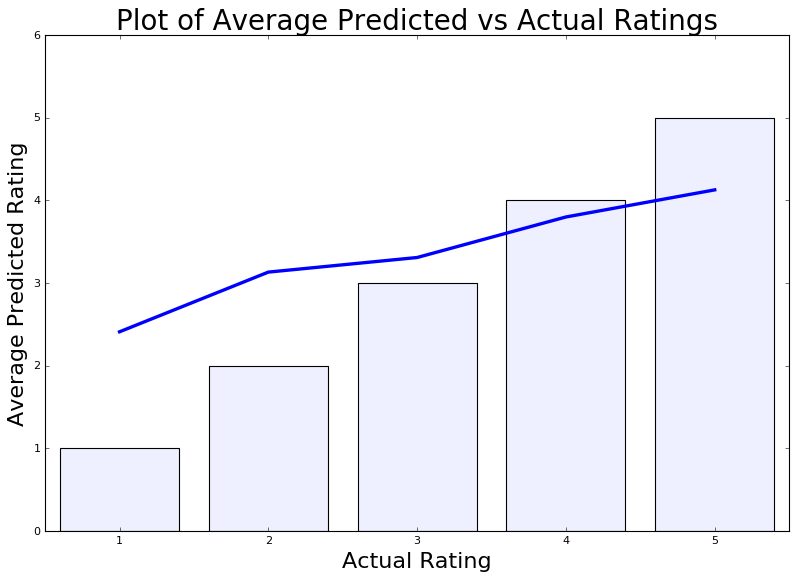

In [43]:
plt.figure(figsize = (12, 8))
plt.bar(np.arange(1,6),rating['rating'], color='#eeefff', align='center')
plt.plot(rating['rating'], rating['AVG_PREDICTION'], linewidth=3, label='Average Prediction')
plt.xlabel('Actual Rating', size=20)
plt.ylabel('Average Predicted Rating', size=20)
plt.title('Plot of Average Predicted vs Actual Ratings', size=25)
plt.ylim([0,6])
plt.xlim([.5,5.5]);

# Part V: Make Recommendations for Users
Here, we display the top two rated movies for ten users in our dataset
* The recommendations have the highest predicted ratings for that specific user
* Algorithm only recommends movies the user has not seen

In [44]:
# Transpose the data using the completely redesigned transpose CAS action - this is running multi-threaded
test=s.transpose(
    table  = dict(name = indata, groupBy = class_inputs[0], vars = target),
    id     = class_inputs[1],
    casOut = dict(name = indata + '_transposed', replace = True)
)
s.CASTable(indata + '_transposed').head()


# Find the movies the users have not watched and predict their potential rating
s.transpose(
    table = dict(name = indata + '_transposed', groupBy = class_inputs[0]),
    casOut = dict(name = indata + '_long', replace = True)
)

s.dataStep.runcode('''
data ''' + indata + '''_long;
    set ''' + indata + '''_long;
    ''' + class_inputs[1] + ''' = 1.0*_NAME_;
    drop _NAME_;
''')

s.fedSQL.execDirect('''
CREATE TABLE scoring_table{options replace=TRUE} AS
    SELECT 
        a.*,
        b.title,
        b.year,
        b.Parental_Rating,
        b.genres
    FROM 
        '''+ indata +'''_long a
        INNER JOIN '''+ movie_info +''' b
    ON
        a.'''+ class_inputs[1] +''' = b.movieId
''')

NOTE: There were 10000 rows read from the table MOVIE_REVIEWS.
NOTE: The table movie_reviews_transposed has 385 rows and 1256 columns.
NOTE: There were 385 rows read from the table MOVIE_REVIEWS_TRANSPOSED.
NOTE: The table movie_reviews_long has 482790 rows and 3 columns.
NOTE: Character values have been converted to numeric values at the places given by: (Line):(Column).
      0:70
NOTE: Table SCORING_TABLE was created in caslib DMlib with 472010 rows returned.


+ Elapsed: 0.285s, user: 0.795s, sys: 0.805s, mem: 251mb

In [47]:
#Make Recommendations
astore = s.CASTable('scoring_table')[all_inputs].query(target + ' is null').astore.score(
  rstore   = dict(name = 'fm_model'),
  out      = dict(name = indata + '_scored_new', replace = True),
  copyVars = class_inputs + ['title']
)

#See top recommendations per user
s.CASTable('movie_reviews_scored_new') \
    .groupby(class_inputs[0]) \
    .sort_values([class_inputs[0], 'P_' + target], ascending = [True, False]) \
    .query("parental_rating ^= 'NA'") \
    .head(2) \
    .head(14)

,P_rating,movie,parental_rating,year,title
usr_id,,,,,
1.0,5.876783,956.0,NOT RATED,1941.0,Penny Serenade
1.0,5.586460,236.0,PG-13,1995.0,French Kiss
2.0,6.097769,1152.0,APPROVED,1948.0,He Walked by Night
2.0,6.011800,1198.0,PG,1981.0,Raiders of the Lost Ark
3.0,5.767734,1152.0,APPROVED,1948.0,He Walked by Night
3.0,5.517265,491.0,PG-13,1993.0,Man Without a Face
4.0,6.609946,236.0,PG-13,1995.0,French Kiss
4.0,6.176431,956.0,NOT RATED,1941.0,Penny Serenade
5.0,5.196706,1198.0,PG,1981.0,Raiders of the Lost Ark


In [49]:
#Close the connection
s.close()